<a href="https://colab.research.google.com/github/googllet/Pracertcbs/blob/main/NeMo_TTS_Primer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.&nbsp;Setup

In [1]:
# Install NeMo library. If you are running locally (rather than on Google Colab), comment out the below lines
# and instead follow the instructions at https://github.com/NVIDIA/NeMo#Installation
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-5vktzyq2/nemo-toolkit_1e2408b3ee5b4aa3aaee977135666fb7
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-5vktzyq2/nemo-toolkit_1e2408b3ee5b4aa3aaee977135666fb7
  Resolved https://github.com/NVIDIA/NeMo.git to commit 76ce1cdf135db38c8d7c858edf987517eace7019
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Download local version of NeMo scripts. If you are running locally and want to use your own local NeMo code,
# comment out the below lines and set NEMO_DIR to your local path.
NEMO_DIR = 'nemo'
!git clone https://github.com/NVIDIA/NeMo.git $NEMO_DIR

fatal: destination path 'nemo' already exists and is not an empty directory.


# 2.&nbsp;Introduction to TTS

This notebook provides a high level overview of text-to-speech (TTS). It will cover high level concepts and discuss each component in a standard TTS pipeline, providing relevant examples and code snippets using [NeMo](https://github.com/NVIDIA/NeMo).

# 3.&nbsp;What is TTS?

**Text-to-speech**, also known as **TTS** or **speech synthesis**, refers to a system by which a computer reads text aloud. Typically the synthesized audio resembles a realistic human voice.

Most TTS models sound like the voice of the speaker whose audio it is trained on. Though some more recently developed algorithms have the potential to sound like real speakers they were not trained on, or sound like entirely new voices.


# 4.&nbsp;The TTS pipeline

Modern TTS systems are fairly complex, with an end to end pipeline consisting of several components that each require their own model or heuristics.

A standard pipeline might look like:

1.   **Text Normalization**: Converting raw text to spoken text (eg. "Mr." &rarr; "mister").<br>
2.   **Grapheme to Phoneme conversion (G2P)**: Convert basic units of text (ie. graphemes/characters) to basic units of spoken language (ie. phonemes).
3.   **Spectrogram Synthesis**: Convert text/phonemes into a spectrogram.
4.   **Audio Synthesis**: Convert spectrogram into audio. Also known as **spectrogram inversion**. Models which do this are called **vocoders**.

While this is the most common structure, there may be fewer or additional steps depending on the use case. For example, some languages do not require G2P and can instead rely on the model to convert raw text/graphemes to spectrogram.

<div>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/tts_pipeline.png" width="500", height="500"/>
</div>

# 5.&nbsp;Text Normalization (TN)

The first step is to pre-process the raw input text into a standardized form. Some examples of processing steps could include:

<table>
  <tr>
    <th>Normalization Type</th>
    <th>Input</th>
    <th>Output</th>
  </tr>
  <tr>
    <td>Abbreviations</td>
    <td>Mr.</td>
    <td>mister<td>
  </tr>
  <tr>
    <td>Acronyms</td>
    <td>TTS</td>
    <td>text to speech<td>
  </tr>
  <tr>
    <td>Numbers</td>
    <td>42</td>
    <td>forty two</td>
  </tr>
  <tr>
    <td>Decimals</td>
    <td>1.2</td>
    <td>one point two</td>
  </tr>
  <tr>
    <td>Roman Numerals</td>
    <td>VII</td>
    <td>seventh</td>
  </tr>
  <tr>
    <td>Cardinal Directions</td>
    <td>N E S W</td>
    <td>north east south west</td>
  </tr>
  <tr>
    <td>URL</td>
    <td>www.github.com</td>
    <td>w w w dot github dot com</td>
  </tr>
</table>

The above examples may be slightly different than the output of the NeMo text normalization code. More details on NeMo text normalization can be found in the [TN documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/intro.html).

A more comprehensive list of text normalization rules, examples, and languages are available in the [code](https://github.com/NVIDIA/NeMo-text-processing/tree/main/nemo_text_processing/text_normalization).



## 5.1&nbsp;TN example

After installing NeMo, we can do text normalization with just a few lines of code.

In [3]:
try:
    from nemo_text_processing.text_normalization.normalize import Normalizer
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        "The package `nemo_text_processing` was not installed in this environment. Please refer to"
        " https://github.com/NVIDIA/NeMo-text-processing and install this package before using "
        "this script"
    )

text_normalizer = Normalizer(input_case="cased", lang="en")

 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
INFO:NeMo-text-processing:Creating ClassifyFst grammars.


In [4]:
text = "Mr. Johnson is turning 35 years old on 04-15-2023."
normalized_text = text_normalizer.normalize(text)

print(text)
print(normalized_text)

Mr. Johnson is turning 35 years old on 04-15-2023.
mister Johnson is turning thirty five years old on april fifteenth twenty twenty three.


## 5.2&nbsp;TN approach

Today text normalization is typically a very manual process involving lots of rules, heuristics, and regular expressions.

It is difficult to train a machine learning model to automate this step due to lack of labeled data. To get ground truth data one would need to manually annotate the entire dataset. The resulting model would then have strictly worse performance than the manual system producing the labels, making it better to use the original labeling system rather than the model.

**Dataset Preparation**

Most common public datasets for TTS modeling are already normalized before they are uploaded, allowing users to skip this step entirely.

When preparing new datasets for training, individuals will often rely on open source libraries for normalization, manually adding new logic into the system as they find situations in their datasets not covered by the pre-existing logic.

This logic is also hard to generalize across *languages*, making scaling TTS to multiple languages very challenging. Enterprises often find it necessary to hire linguists for every language they operate in, whose responsibility is to manually develop and improve the text processing and normalization for their specific languages and users.

# 6.&nbsp;Grapheme to Phoneme (G2P)

Next we convert the written text into **phonemes**, the most basic unit of human speech.

For example (using [ARPABET](https://en.wikipedia.org/wiki/ARPABET)): *Hello World &rarr; HH, AH0, L, OW1, ,W, ER1, L, D*

Some languages, such as Spanish and German, are *phonetic*, meaning their written characters/graphemes are always pronounced the same. For such languages G2P is unnecessary.

However English is not Phonetic because:
*   Characters change pronunciation depending on what word they are in.
*   Some phonemes are represented by multiple characters (eg. "ch", "th", "ph")
*   Some words are [Heteronyms](https://en.wikipedia.org/wiki/Heteronym_(linguistics%29#English), which are words with the same spelling but different pronunciation or meaning.
  * For example, "read" is pronounced differently depending on whether it is present tense or past tense.
  * Some heteronyms can be disambiguated based on what part of speech they are. But some, such as bass (fish or instrument), can only be disambiguated based on meaning/context.

For non-phonetic languages like English it is still possible to train a TTS model directly on the graphemes. But doing so will make the pronunciation of some words less accurate.

Details on how NeMo G2P works can be found in our [G2P documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/g2p.html).

## 6.1&nbsp;Phonetic Alphabets

There are several different alphabets that can be used to represent the phonetic pronunciation of a sentence.

The most common phonetic alphabet is the **International Phonetic Alphabet (IPA)**, which provides a common set of phonemes for all languages.

For English, **ARPABET** is also very common. Largely due to the popularity of the [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict).

## 6.2&nbsp;G2P example

We will show how to do both IPA and ARPABET G2P using NeMo.


In [5]:
import os
from nemo.collections.tts.g2p.models.en_us_arpabet import EnglishG2p
from nemo.collections.tts.g2p.models.i18n_ipa import IpaG2p

ipa_dict_path = os.path.join(NEMO_DIR, "scripts", "tts_dataset_files", "ipa_cmudict-0.7b_nv23.01.txt")

# EnglishG2p uses the CMU dictionary by default, if none is provided
arpabet_g2p = EnglishG2p()
ipa_g2p = IpaG2p(phoneme_dict=ipa_dict_path)

[NeMo E 2025-05-07 15:20:42 nemo_logging:417] Torch distributed needs to be initialized before you initialized EnglishG2p. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2025-05-07 15:20:42 nemo_logging:405] English g2p_dict will be used from nltk.corpus.cmudict.dict(), because phoneme_dict_path=None. Note that nltk.corpus.cmudict.dict() has old version (0.6) of CMUDict. You can use the latest official version of CMUDict (0.7b) with additional changes from NVIDIA directly from NeMo using the path scripts/tts_dataset_files/cmudict-0.7b_nv22.10.
[NeMo W 2025-05-07 15:20:43 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-05

In [6]:
text = "Hello world"
arpabet_phonemes = arpabet_g2p(text)
ipa_phonemes = ipa_g2p(text)

print(text)
print(arpabet_phonemes)
print(ipa_phonemes)

Hello world
['h', 'e', 'l', 'l', 'o', ' ', 'W', 'ER1', 'L', 'D']
['H', 'E', 'L', 'L', 'O', ' ', 'ˈ', 'w', 'ɝ', 'l', 'd']


Notice that graphemes are returned for the word "hello" rather than the ARPABET phonemes.

This is because the English G2P module uses its dictionary to map graphemes to phonemes. The word "hello" has two possible pronunciations.

In [7]:
print(arpabet_g2p.phoneme_dict['hello'])

[['HH', 'AH0', 'L', 'OW1'], ['HH', 'EH0', 'L', 'OW1']]


Since the pronunciation is *ambiguous*, it returns the graphemes instead. By default it will also do this for any word **out of vocabulary (oov)** words that are not in the CMU dictionary.

In general, handling ambiguous pronunciations is a difficult problem which we will discuss more below.

For now, we can tell the G2P module to simply return the first pronunciation in the dictionary by setting `ignore_ambiguous_words=False`.

In [8]:
arpabet_g2p = EnglishG2p(ignore_ambiguous_words=False)
ipa_g2p = IpaG2p(phoneme_dict=ipa_dict_path, ignore_ambiguous_words=False)

[NeMo E 2025-05-07 15:20:44 nemo_logging:417] Torch distributed needs to be initialized before you initialized EnglishG2p. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2025-05-07 15:20:44 nemo_logging:405] English g2p_dict will be used from nltk.corpus.cmudict.dict(), because phoneme_dict_path=None. Note that nltk.corpus.cmudict.dict() has old version (0.6) of CMUDict. You can use the latest official version of CMUDict (0.7b) with additional changes from NVIDIA directly from NeMo using the path scripts/tts_dataset_files/cmudict-0.7b_nv22.10.
[NeMo W 2025-05-07 15:20:45 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-05

In [9]:
text = "Hello world"
arpabet_phonemes = arpabet_g2p(text)
ipa_phonemes = ipa_g2p(text)

print(text)
print(arpabet_phonemes)
print(ipa_phonemes)

Hello world
['HH', 'AH0', 'L', 'OW1', ' ', 'W', 'ER1', 'L', 'D']
['h', 'ə', 'ˈ', 'l', 'o', 'ʊ', ' ', 'ˈ', 'w', 'ɝ', 'l', 'd']


**Tokenization**

At the end of G2P we have a list of characters. In order for our model to process these characters, we need to convert them into numbers.

To do this we have a vocabulary containing all characters in our alphabet. Each character gets assigned a fixed number, such that every time it shows up in the text it is replaced with that number.

In [10]:
from nemo.collections.tts.torch.tts_tokenizers import EnglishPhonemesTokenizer, IPATokenizer

arpabet_tokenizer = EnglishPhonemesTokenizer(arpabet_g2p)
ipa_tokenizer = IPATokenizer(ipa_g2p)

[NeMo W 2025-05-07 15:20:47 nemo_logging:405] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` is experimental and not ready for production yet. Use at your own risk.


In [11]:
text = "Hello world"
arpabet_tokens = arpabet_tokenizer(text)
ipa_tokens = ipa_tokenizer(text)

print(text)
print(arpabet_tokens)
print(ipa_tokens)

Hello world
[7, 27, 10, 36, 0, 21, 32, 10, 3]
[18, 40, 51, 22, 25, 48, 54, 51, 31, 43, 22, 15]


## 6.3&nbsp;G2P approach

Similar to Text Normalization, most G2P systems today are very manual.

Most of the earlier descriptions about Text Normalization are also the same for G2P, in regards to it being difficult to get labeled data to train a machine learning model to do it automatically and challenging to generalize and scale across languages.

The most common way that G2P is done today is to hardcode the grapheme to phoneme mapping for all common words in a language in a **pronouncing dictionary**.

A few examples of dictionary entries:
```
CAT  K AE1 T
HELLO  HH AH0 L OW1
NVIDIA  EH0 N V IY1 D IY0 AH0
```

This works decently for languages like English which have comprehensive dictionaries, but does not help for the large number of languages for which no such dictionary is available.

But even with a good dictionary, there are still a few problems.

*   Text with **out of vocabulary (oov)** words that are not in the dictionary
*   **Heteronyms**: Two words with the same spelling but different pronunciations or meaning.



### 6.3.1&nbsp;Out of Vocabulary (OOV)

Figuring out how to pronounce unknown words is difficult. Even native English speakers have a hard time pronouncing unfamiliar words and often have to look up the correct pronunciation.

**Dictionary Management**

The most straightforward way to deal with OOV words is to manually add them to your dictionary. Not very sustainable, but the only method guaranteed to be accurate.

For a TTS application, it is often a good idea to give individual users the option to create and manage their own dictionary so they can fix any mistakes on their own in real-time.

**Grapheme-Based TTS Training**

Training a model to generate audio from graphemes will (in theory) teach it to implicitly learn G2P rules based on its training data.

Training on only graphemes will typically result in poorer overall performance than training on phonemes.

NeMo also supports **mixed grapheme-phoneme training** in which the model is trained on inputs which contain both graphemes and phonemes. Doing this may teach the model to pronounce optimally with phonemes while also providing reasonable out-of-the-box behavior on OOV words and heteronyms.

To do mixed training, the `EnglishG2p()` class has a `phoneme_probability` parameter which allows you to specify how likely each word will be left as graphemes at training time.

**Machine Learning Model**

Given a pronunciation dictionary, one can train a machine learning model to try and predict phonemes from graphemes. Or the dictionary can be run on a full text corpus, and the model can be trained on the sentences in the corpus.

The resulting model will have lower prediction accuracy than the dictionary or G2P system it is trying to replicate, but it will be possible to run the model over OOV words the original dictionary could not process.

### 6.3.2&nbsp;Heteronyms

There are not many good ways today to handle a word having multiple pronunciations.

The Grapheme-based training methods mentioned for OOV words can also be used here.

Another common approach relies on the fact that most (but not all) heteronyms can be disambiguated based on what part-of-speech they are.

*   Create an extra dictionary mapping heteronyms to phonemes based on what part-of-speech they are.
*   Use a [part-of-speech-tagger](https://en.wikipedia.org/wiki/Part-of-speech_tagging) to tag heteronyms.

# 7.&nbsp;Spectrogram Synthesis

The most complicated step is converting the text or phonemes into a spectrogram representing the spoken audio.




## 7.1&nbsp;Audio

Audio is typically represented by a long sequence of numbers representing the audio amplitude at each point in time.

How often the audio samples are recorded is the [sampling rate](https://en.wikipedia.org/wiki/Sampling_(signal_processing)). Common sampling rates are 16 kHz, 22.05 kHz, and 44.1 kHz, with higher sampling rates producing more accurate, higher quality audio.

A sampling rate of 44.1 kHz means that we store 44,100 audio sample per second of audio. Each audio sample is typically stored as a 16-bit integer (a whole number ranging from -32,768 to +32,767). For machine learning, it is sometimes more convenient to rescale it and represent it as a continuous value between -1.0 and 1.0 using 32-bit floats.

<br>
<center>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/sampling_rate.png" width="800", height="300"/>
<figcaption>https://wiki.hydrogenaud.io/index.php?title=File:Digital_wave.png
</figcaption>
</center>

## 7.2&nbsp;Spectrograms

While raw audio shows amplitude versus time and is useful for easily recording and listening, it is not optimal when it comes to processing.

For processing, it is usually preferable to represent the audio as a **spectrogram** which shows frequency versus time. Specifically, we:

1.   Group together audio samples into a much smaller set of time buckets, called **audio frames**. An audio frame will usually bucket around 50ms of audio.
2.   For each audio frame, use the [Fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (**FFT**) to calculate the magnitude (ie. energy, amplitude or "loudness") and phase (which we don't use) of each frequency bin. We refer to the magnitudes of the frequency bins as a spectrogram
3.   Map the original frequency bins onto the [mel scale](https://en.wikipedia.org/wiki/Mel_scale), using overlapped [triangular filters](https://en.wikipedia.org/wiki/Window_function#Triangular_window) to create mel filterbanks.
4.   Multiply the original spectrogram by the mel filterbanks to produce a mel spectrogram (for more details see [here](https://www.mathworks.com/help/audio/ref/melspectrogram.html)).

We then use the mel spectrogram as our final audio representation. The only thing we lose during this process is the phase information, the implications of which we will discuss more later on.

The reason for converting from hertz to mel frequency is that hertz are a physical measurement, while mel frequency better captures how humans perceive sound. Human ears are more sensitive to low frequencies than high frequencies. So low frequency bands would have large impact on the perceived sound while high frequency bands might have little to no effect. On the mel scale, the impact of different frequency bands are more evenly distributed.

## 7.3&nbsp;Why use a spectrogram?



In addition to the mel spectrogram providing handcrafted features that are closer to human perception and easier to predict, there are a few other advantages to using it over audio samples.

**1. Computational Efficiency**

One reason to use a spectrogram is that it is a lot more computationally efficient than processing raw audio.

Take for example a 10 second piece of audio sampled at 44.1 kHz.

This audio has 10 * 44,100 = 441,000 audio samples.

For TTS we will represent this same audio with audio frames that are overlapping such that there is about 1 audio frame per 10ms (0.01s). For each audio frame we have 80 frequency bands.

Our final spectrogram has 80 bands * 10s * / (0.01s) = 80,000

So we made our data about 5 times smaller.

Even in other fields that deal with audio, such as *digital signal processing (DSP)*, it is common practice to reduce computation time by computing the FFT, running mathematical calculations and manipulations in the frequency domain, and then converting the final spectrogram back to audio with the *inverse* FFT.

**2. Shorter 2D sequence length**

In the example above, the dimension of our input goes from being (441,000, 1) to (1000, 80). Instead of having a very long 1-dimensional time series, we instead have a much shorter sequence of multi-dimensional features.

This dimensionality works better with most modern deep learning models.

Most models work better representing large chunks/sequences of information as higher dimension vectors (eg. *embeddings*).

**RNN/LSTM** architectures have latency proportional to the length of the sequence, can struggle to remember information for sequences over a few hundred tokens long, and are more prone to vanishing/exploding gradients as the sequence gets longer.

With 2 dimensions we can effectively use **CNNs** by running [temporal convolutions](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html?highlight=conv1d#torch.nn.Conv1d) over the time dimension. Or by applying [2d convolutions](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d) to the spectrogram exactly as if it were an image in computer vision.

**Transformers** require computation/memory that is proportional to the length of the sequence squared. This means we can easily use large transformers for relatively short sequences like in NLP, smaller transformers for longer sequences like spectrogram data, and are impractical to use on very long sequences like audio samples.

## 7.4&nbsp;End to end example

Before we go into the details of how this works, let's go through an end-to-end text to audio example so we can visualize what our model inputs and outputs look and sound like.

To do this, we will need to use both the spectrogram and vocoder models together. The vocoder will be looked at more thoroughly in the *audio synthesis* section.

In [12]:
import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

# List pretrained models available in NeMo
print("Spectrogram Models")
print(SpectrogramGenerator.list_available_models())

print()
print("Vocoders")
print(Vocoder.list_available_models())

Spectrogram Models
[PretrainedModelInfo(
	pretrained_model_name=tts_en_fastpitch,
	description=This model is trained on LJSpeech sampled at 22050Hz with and can be used to generate female English voices with an American accent. It is ARPABET-based.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo,
	class_=<class 'nemo.collections.tts.models.fastpitch.FastPitchModel'>
), PretrainedModelInfo(
	pretrained_model_name=tts_en_fastpitch_ipa,
	description=This model is trained on LJSpeech sampled at 22050Hz with and can be used to generate female English voices with an American accent. It is IPA-based.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/IPA_1.13.0/files/tts_en_fastpitch_align_ipa.nemo,
	class_=<class 'nemo.collections.tts.models.fastpitch.FastPitchModel'>
), PretrainedModelInfo(
	pretrained_model_name=tts_en_fastpitch_multispeaker,
	description=This model is trained o

In [13]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

# Load our spectrogram and vocoder models onto our CPU
spectrogram_model = SpectrogramGenerator.from_pretrained("tts_en_tacotron2").eval().to(device)
vocoder = Vocoder.from_pretrained("tts_en_hifigan").eval().to(device)

[NeMo I 2025-05-07 15:20:47 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.10.0/files/tts_en_tacotron2.nemo to /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo
[NeMo I 2025-05-07 15:20:48 nemo_logging:393] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
INFO:NeMo-text-processing:Creating ClassifyFst grammars.
[NeMo W 2025-05-07 15:21:30 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-05-07 15:21:30 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /raid/datasets/tts_data/train_manifest.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
     

[NeMo I 2025-05-07 15:21:30 nemo_logging:393] PADDING: 16
[NeMo I 2025-05-07 15:21:30 nemo_logging:393] STFT using exact pad
[NeMo I 2025-05-07 15:21:31 nemo_logging:393] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.
[NeMo I 2025-05-07 15:21:31 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2025-05-07 15:21:33 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo W 2025-05-07 15:21:39 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2025-05-07 15:21:39 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segmen

[NeMo I 2025-05-07 15:21:39 nemo_logging:393] PADDING: 0


[NeMo W 2025-05-07 15:21:39 nemo_logging:405] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2025-05-07 15:21:39 nemo_logging:393] PADDING: 0
[NeMo I 2025-05-07 15:21:41 nemo_logging:393] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [14]:
text = "This audio was generated with a text-to-speech model."

# Normalize the text and convert it into individual phonemes/tokens.
tokens = spectrogram_model.parse(text, normalize=True)

# Generate spectrogram from text
spectrogram = spectrogram_model.generate_spectrogram(tokens=tokens)

# Invert the spectrogram into audio samples
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

# Convert output from pytorch tensor to numpy array
spectrogram = spectrogram.cpu().detach().numpy()[0]
audio = audio.cpu().detach().numpy()[0]

In [15]:
print(f'"{text}"\n')

ipd.Audio(audio, rate=22050)

"This audio was generated with a text-to-speech model."



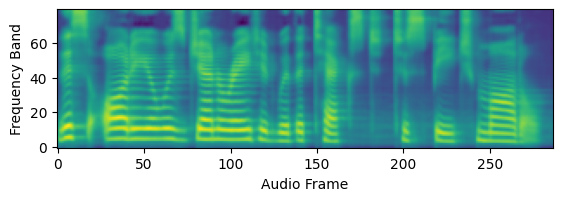

In [16]:
# Visualize the spectrogram
imshow(spectrogram, origin="lower")
plt.xlabel("Audio Frame")
plt.ylabel("Frequency Band")
plt.show()

## 7.5&nbsp;Model types

Predicting a spectrogram from text is a **sequence-to-sequence** problem because the input and output are different lengths. The length of the output is itself ambiguous, and something the model needs to predict.

Most successful approaches to this problem use an **encoder-decoder** system. The typical pattern looks like:

1.   The model has a **character embedding** for each character in its vocabulary. This is usually learned from scratch during training, but can also be pre-trained or augmented with generic language embeddings like *BERT*.
2.   The **encoder** analyzes the input sentence and applies various transformations to each character embedding in the output sequence. The *encoder outputs* are character embeddings that represent how each character should be *pronounced*, given the sentence. Encoders will also usually encode the approximate length, or **duration**, of each character.
3.   The **decoder** predicts the spectrogram using the sequence of character pronunciation embeddings provided by the encoder.

Most model architectures rely on **RNNs** or **Transformers** to do sentence-level processing (like how to pronounce or emphasize certain words based on the meaning of the sentence), and **CNNs** to process features based on their adjacent characters or audio frames (like how to start and end a word to make it flow naturally with the previous and next words).

Today there are two main categories of these encoder-decoder systems: **auto-regressive** models and **parallel** models. Within these categories, parallel models typically use **duration prediction**, while auto-regressive models can use duration prediction or **attention**.

## 7.6&nbsp;Auto Regressive Models

### 7.6.1&nbsp;Tacotron 2

The first good neural TTS models were auto-regressive models such as [Tacotron 2](https://google.github.io/tacotron/publications/tacotron2/index.html).

For these models, the encoder encodes the input sentence, and then the decoder predicts the spectrogram one audio frame at a time. This lets the model condition each spectrogram frame on the frames before it, producing high quality audio.

Let's take a quick look at the Tacotron 2 architecture.

<br>
<div>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/tacotron2_diagram.png" width="600", height="500"/>
</div>

The model is fairly complex. At a high level, it contains:

1.   A CNN-RNN *encoder* which uses a bidirectional LSTM to analyze the entire sentence forward and backwards to figure out the pronunciation of every character.
2.   A unidirectional LSTM *decoder* which predicts the spectrogram one frame at a time.
3.   An **attention** mechanism that the decoder uses to determine which character(s) to look at when generating specific audio frames.
4.   A *stop token* layer which predicts a single number [0, 1] to determine the probability that the decoder has reached the end of the sentence.
5.   A *pre-net* that feeds the previous predicted frame into the decoder before predicting the next frame. This is used primarily for **teacher forcing** so that the model can learn effectively.
6.   A *post-net* which post-processes the entire spectrogram produced by the decoder to fix inconsistencies and smooth it out.

The attention and teacher forcing mechanisms are the main characteristics that define the auto-regressive model and differentiate it from non-auto-regressive systems. These will be discussed in more detail below.

The post-net is an optional optimization.

The specifics of the encoder and decoder are not too important, and can be replaced with any equivalent combination of RNN, CNN, and/or Transformer blocks.



### 7.6.2&nbsp;Attention and Alignment

An auto-regressive model predicts the spectrogram based primarily on the encoder output features. For the output to make sense, each audio frame produced needs to be based on a subset of the characters in the input. Which character(s) the decoder is using when it predicts an audio frame is called its **attention**.

First, let's see what our Tacotron 2 attention looks like.

In [17]:
import torch
from nemo.collections.tts.models import Tacotron2Model

Tacotron2Model.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=tts_en_tacotron2,
 	description=This model is trained on LJSpeech sampled at 22050Hz, and can be used to generate female English voices with an American accent.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.10.0/files/tts_en_tacotron2.nemo,
 	class_=<class 'nemo.collections.tts.models.tacotron2.Tacotron2Model'>
 )]

In [18]:
tacotron2_model = Tacotron2Model.from_pretrained("tts_en_tacotron2").eval().to(device)
tacotron2_model.calculate_loss = False

g2p = EnglishG2p(ignore_ambiguous_words=False)

[NeMo I 2025-05-07 15:21:50 nemo_logging:393] Found existing object /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.
[NeMo I 2025-05-07 15:21:50 nemo_logging:393] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo
[NeMo I 2025-05-07 15:21:50 nemo_logging:393] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
INFO:NeMo-text-processing:Creating ClassifyFst grammars.
[NeMo W 2025-05-07 15:22:39 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-05-07 15:22:39 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /raid/datasets/tts_data/train_manifest.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
     

[NeMo I 2025-05-07 15:22:39 nemo_logging:393] PADDING: 16
[NeMo I 2025-05-07 15:22:39 nemo_logging:393] STFT using exact pad
[NeMo I 2025-05-07 15:22:40 nemo_logging:393] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.


[NeMo E 2025-05-07 15:22:40 nemo_logging:417] Torch distributed needs to be initialized before you initialized EnglishG2p. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2025-05-07 15:22:40 nemo_logging:405] English g2p_dict will be used from nltk.corpus.cmudict.dict(), because phoneme_dict_path=None. Note that nltk.corpus.cmudict.dict() has old version (0.6) of CMUDict. You can use the latest official version of CMUDict (0.7b) with additional changes from NVIDIA directly from NeMo using the path scripts/tts_dataset_files/cmudict-0.7b_nv22.10.
[NeMo W 2025-05-07 15:22:41 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


In [19]:
text = "This is an attention map."

tokens = tacotron2_model.parse(text, normalize=True)
token_len = torch.tensor([tokens.shape[1]], dtype=torch.long, device=spectrogram_model.device)

_, _, _, alignments, _ = tacotron2_model.forward(tokens=tokens, token_len=token_len)
alignment = alignments[0].cpu().detach().numpy()

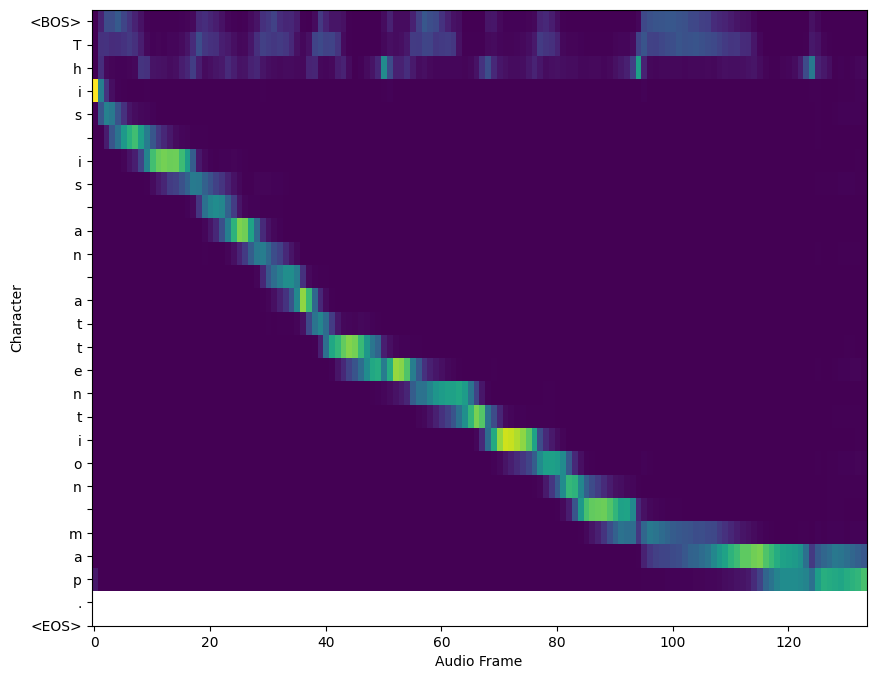

In [20]:
# Pretrained Tacotron 2 uses grapheme input with beginning-of-speech and end-of-speech tokens
characters = ["<BOS>"] + [char for char in text] + ["<EOS>"]

fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel("Audio Frame")
plt.ylabel("Character")
_ = ax.imshow(alignment.transpose(), origin='upper', aspect='auto')
_ = ax.set_yticks(range(len(characters)))
_ = ax.set_yticklabels(characters)

In order to get good quality output, we need our model's attention to follow these constraints:

*   The decoder should pay attention to one character at a time (sometimes it also places weight on the one character immediately before and/or after it).
*   The attention should be **monotonically increasing**, meaning it never go backwards in the text sequence. So the attention should only ever stay on the current character, or move forward to the next character.
*   The model should start on the first character in the sequence and end on the last character.

These constraints result in the decoder effectively "reading" the text character by character or word by word, similar to how humans read aloud.

A model may need to be trained for a while before its attention learns to follow these constraints. Before that, the attention may look non-sensical, and the model output will sound unintelligible.

Once the models learns the above constraints and starts producing well-behaved attention maps, it is said that the model has **aligned**.

**Attention Mechanisms**

A large number of different systems have been developed over time to model TTS attention. Historically a lot of these mechanisms would use various inputs (decoder state, previous prediction, previous attention weights, etc) during each decoder step to predict a softmax across all characters in the sentence.

This works decently, but is not very good at enforcing the constraints listed above. A better [alternative](https://arxiv.org/abs/2108.10447) is to model the attention similar to a *Hidden Markov Model*; a state machine in which each character in the text is a state and the only valid state transitions are to stay on the current character or move forward 1 character.

### 7.6.3&nbsp;Training Features and Teacher Forcing

Another very important aspect of TTS modeling is **teacher forcing**, which means that during training we provide various pieces of ground truth information to the model and at inference provide equivalent predicted values.

Training a model to directly predict a spectrogram from text by itself does not work, for a few reasons:

*   Spectrogram Synthesis is a difficult enough problem that most models will not converge to anything meaningful if its only input is text.
*   The prediction target is extremely *ambiguous*. There are several correct ways to read any sentence. For training to be smooth, the input features need to be enough to figure out the speaking pattern for most training utterances.

The most standard form of teacher forcing in auto-regressive systems is for each decoder step to receive the ground truth prediction from the previous step. In other words, each decoder step predicts an audio frame. During training, the ground truth audio frame is passed to the next decoder step. During inference, the predicted audio frame is passed to the next decoder step. In Tacotron 2, the pre-net applies a large amount of dropout to this input to avoid overfitting.

Some other common forms of ground truth information that have been found to be useful are:

*   **Pitch**: By providing the pitch, aka. the [fundamental frequency](https://en.wikipedia.org/wiki/Fundamental_frequency) **(F0)**, for each character, a model is able to better learn and mimic a variety of natural speaking patterns.
*   **Speaking Rate**: By providing the length of the ground truth spectrogram as an input feature, the model is able to easily disambiguate how long the final audio should be. At inference time a user can then manually change the input value to make the model speak as slow or as fast as they want.
*   **Style Embeddings**: By training an *auto-encoder* on the TTS training data, it is possible to represent very complex speaking styles with utterance-level embeddings. Taking a style embedding from one utterance to make a speaker say a different sentence with the same speaking characteristics is referred to as **style transfer**.


### 7.6.4&nbsp;Ground Truth Aligned (GTA) Inference

Let's take an utterance and compare the output of Tacotron2 when teacher forcing is used versus when it is not. The teacher forcing ensures that the predicted spectrogram is the same length as the ground truth spectrogram, so this type of inference is often referred to as being **ground truth aligned (GTA)**.

In [21]:
import wget

audio_path = "LJ023-0089.wav"
audio_url = "https://multilangaudiosamples.s3.us-east-2.amazonaws.com/LJ023-0089.wav"

if not os.path.exists(audio_path):
  wget.download(audio_url, audio_path)

In [22]:
import librosa

# Process text input
text = "That is not only my accusation."

tokens = tacotron2_model.parse(text, normalize=True)
token_len = torch.tensor([tokens.shape[1]], dtype=torch.long, device=tacotron2_model.device)

# Run regular inference
_, predicted_spectrogram, _, _, _ = tacotron2_model.forward(tokens=tokens, token_len=token_len)
predicted_audio = vocoder.convert_spectrogram_to_audio(spec=predicted_spectrogram)
predicted_audio = predicted_audio.cpu().detach().numpy()[0]

# Process the ground truth audio
sample_rate = 22050
audio, _ = librosa.load(audio_path, sr=sample_rate)

audio_tensor = torch.from_numpy(audio).unsqueeze(0).to(tacotron2_model.device)
audio_len = torch.tensor(audio_tensor.shape[1], dtype=torch.long, device=tacotron2_model.device).unsqueeze(0)

# Run GTA inference. This is a bit awkward to set up as Tacotron2 only expects to do this at training time.
tacotron2_model.calculate_loss = True
tacotron2_model.training = True
tacotron2_model.decoder.training = True
_, gta_spectrogram, _, _, _, _ = tacotron2_model.forward(
    tokens=tokens,
    token_len=token_len,
    audio=audio_tensor,
    audio_len=audio_len
)
tacotron2_model.calculate_loss = False
tacotron2_model.training = False
tacotron2_model.decoder.training = False

gta_audio = vocoder.convert_spectrogram_to_audio(spec=gta_spectrogram)
gta_audio = gta_audio.cpu().detach().numpy()[0]

In [23]:
print(f'"{text}"\n')

print("Original Audio")
ipd.display(ipd.Audio(audio, rate=sample_rate))

print("GTA Audio")
ipd.display(ipd.Audio(gta_audio, rate=sample_rate))

print("Predicted Audio")
ipd.display(ipd.Audio(predicted_audio, rate=sample_rate))

"That is not only my accusation."

Original Audio


GTA Audio


Predicted Audio


We see that with teacher forcing, the model output sounds almost exactly like the original audio. This is how the model learns how to generate audio that sounds realistic and high-quality.

However, at inference time we see that the pitch of the speaker is very different. Without teacher forcing, and without receiving the pitch as an input feature, the model has no way of knowing what pitch to use. So most likely, all predicted utterances will end up using the average pitch observed at training time.

## 7.7&nbsp;Duration Prediction


A large weakness of the original Tacotron 2 model is its attention mechanism, which does not enforce the required monotonicity constraint (ie. the decoder must pay attention to each character once in sequential increasing order). As a result, the attention is not robust. It often skips words, repeats words, or encounters catastrophic failures where the output becomes unintelligible.

There are some attention mechanisms such as [forward attention](https://arxiv.org/abs/1807.06736) which try to address this.

The most standard approach today is to do **explicit duration prediction**. This means that the model encoder predicts the duration (ie. number of spectrogram frames) of each character directly, instead of relying on the attention to determine it implicitly.

Replacing the attention mechanism in Tacotron 2 with duration prediction, eg. [Non-Attentive Tacotron](https://arxiv.org/abs/2010.04301), has historically been a common and necessary optimization to make it robust enough for use in enterprise applications. Though it gained visibility in academic literature primarily due to its use in modern transformer based model architectures such as [FastSpeech](https://arxiv.org/abs/1905.09263) and [FastPitch](https://fastpitch.github.io/).

The biggest drawback of this approach is that you need to get the ground truth character duration information. Some methods for doing this are:

1.   The preferred method in NeMo is to Jointly train an [alignment model](https://arxiv.org/abs/2108.10447) that measures the similarity between characters and spectrogram frames.
2.   Run forced alignment, such as with the [Montreal Forced Aligner](https://montreal-forced-aligner.readthedocs.io/en/latest/).
3.   Infer the duration information from the attention map of a teacher model, such as Tacotron 2.

## 7.8&nbsp;Parallel Models


There are some significant weaknesses to auto-regressive systems. Most notably:

*  Spectrograms are long (100s-1000s of frames), so generating them one frame at a time makes inference slow.
*  They are typically implemented using RNN based architectures, which are slow to train.
*  The user has little control over how the sentence is spoken.

Using duration prediction enables us to remove the auto-regressive inference and predict every spectrogram frame in parallel. This makes the inference speed up to 100x faster, making it highly preferable for deploying and serving to users.

### 7.8.1&nbsp;FastPitch

In NeMo we support [FastPitch](https://fastpitch.github.io/), a parallel transformer-based model with pitch and duration control and prediction.

<div>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/fastpitch_diagram.png" width="600", height="500"/>
</div>

At a high level it contains:

1.   An encoder consisting of a **feed-forward transformer block (FFTr)**, which transforms the input character embeddings into character pronunciation embeddings.
2.   A temporal CNN which takes the encoder output and predicts the duration and pitch of each character. At training time, the ground truth pitch and duration information are fed to the model (similar to teacher forcing).
3.   Each encoder output is repeated a number of times equal to the predicted duration. The repeated encoder output is the same length as the final spectrogram. For example, for characters 'abc' and predicted durations (2, 3, 1) we get the encoder output repeated 'aabbbc'.
4.   A decoder consisting of a FFTr that transforms this encoder output into the predicted spectrogram.

Some advantages to this approach are:

*   The duration prediction makes the output consistent and robust.
*   The model inference is fast, able to synthesize up to 1000 seconds of audio every second on an A100 GPU.
*   You can customize the prosody by manually selecting the pitch and duration of each character or word.

Let's run the same inference for FastPitch that we did with Tacotron2. The main difference is loading the FastPitch checkpoint using the `FastPitchModel` class.

In [24]:
from nemo.collections.tts.models import FastPitchModel

fastpitch_model = FastPitchModel.from_pretrained("tts_en_fastpitch").eval().to(device)

[NeMo I 2025-05-07 15:23:31 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo to /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo
[NeMo I 2025-05-07 15:23:36 nemo_logging:393] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
INFO:NeMo-text-processing:Creating ClassifyFst grammars.
[NeMo W 2025-05-07 15:24:34 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-05-07 15:24:34 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 10

[NeMo I 2025-05-07 15:24:34 nemo_logging:393] PADDING: 1
[NeMo I 2025-05-07 15:24:34 nemo_logging:393] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.4.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.


In [25]:
text = "This audio was generated with the fastpitch text-to-speech model."

# Normalize the text and convert it into individual phonemes/tokens.
tokens = fastpitch_model.parse(text, normalize=True)

# Generate spectrogram from text
spectrogram = fastpitch_model.generate_spectrogram(tokens=tokens)

# Invert the spectrogram into audio samples
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

# Convert output from pytorch tensor to numpy array
spectrogram = spectrogram.cpu().detach().numpy()[0]
audio = audio.cpu().detach().numpy()[0]

In [26]:
print(f'"{text}"\n')

ipd.Audio(audio, rate=22050)

"This audio was generated with the fastpitch text-to-speech model."



### 7.8.2&nbsp;Drawbacks

One weakness of parallel models is that without auto-regressive teacher forcing, the model is unable to reliably predict/reconstruct the original utterance. Primarily due to the inputs not fully capturing the unpredictable variability/ambiguity in the possible outputs. The result is that the model learns an average over possible outputs, creating spectrograms that look unrealistically "smooth", degrading the audio quality (https://arxiv.org/abs/2202.13066).

This problem can be partially alleviated by fine-tuning the spectrogram inversion model (described in the next section) directly on the predicted spectrograms.

To visualize this, let's compare a spectrogram to the corresponding one predicted by FastPitch.

In [27]:
# Compute real spectrogram
audio_path = "LJ023-0089.wav"
sample_rate = 22050

audio, _ = librosa.load(audio_path, sr=sample_rate)
audio_tensor = torch.from_numpy(audio).unsqueeze(0).to(fastpitch_model.device)
audio_len = torch.tensor(audio_tensor.shape[1], dtype=torch.long, device=fastpitch_model.device).unsqueeze(0)

real_spectrogram, _ = fastpitch_model.preprocessor(input_signal=audio_tensor, length=audio_len)
real_spectrogram = real_spectrogram.cpu().detach().numpy()[0]

# Run FastPitch inference
text = "That is not only my accusation."

tokens = fastpitch_model.parse(text, normalize=True)
predicted_spectrogram = fastpitch_model.generate_spectrogram(tokens=tokens)
predicted_spectrogram = predicted_spectrogram.cpu().detach().numpy()[0]

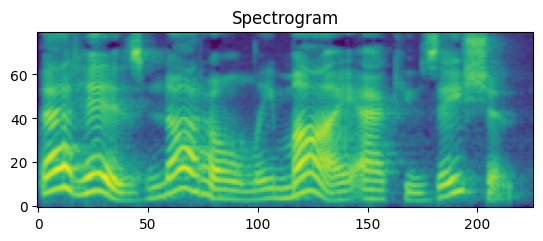

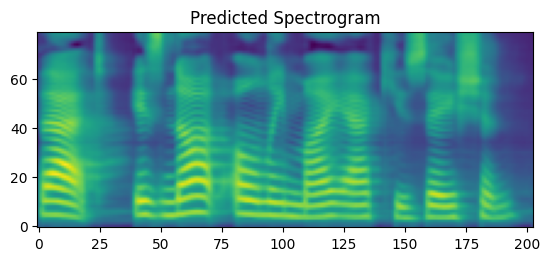

In [28]:
# Compare the spectrograms
imshow(real_spectrogram, origin="lower")
plt.title("Spectrogram")
plt.show()

imshow(predicted_spectrogram, origin="lower")
plt.title("Predicted Spectrogram")
plt.show()

As we can see, the predicted spectrogram looks very smooth and well-behaved compared to the ground truth which has a more variation and detail.

## 7.9&nbsp;Research

There is ongoing research into improving the audio quality and expressiveness of models like FastPitch, with a few methods that have shown promising results being:

1.   Train a [variational auto-encoder](https://en.wikipedia.org/wiki/Variational_autoencoder) (VAE) that can compress all utterance-level variation/prosody into an embedding and provide it as a feature it to the decoder (https://arxiv.org/abs/1812.04342).
2.   Use [normalizing flows](https://arxiv.org/abs/1908.09257) (sometimes called *glow* models) to directly learn the variability in the training data (eg. [RAD-TTS](https://nv-adlr.github.io/RADTTS)).
3.   Use [generative adversarial networks](https://en.wikipedia.org/wiki/Generative_adversarial_network) (GAN) based training to make the predicted spectrograms harder to tell apart from real spectrograms.
4.   Avoid the spectrogram entirely by training an end-to-end model that can go directly from text to audio (eg. [VITS](https://arxiv.org/pdf/2106.06103.pdf)).

# 8.&nbsp;Audio Synthesis (Spectrogram Inversion)

Reconstructing audio from a spectrogram can theoretically be done using the [inverse FFT](https://pytorch.org/docs/stable/generated/torch.fft.ifft.html?highlight=fft) (iFFT). However there are a few complications in doing this with our model.

1.   The mel spectrogram does not contain the phase information output by the original FFT.
2.   The predicted spectrogram is imperfect. It is likely smoother than the ground truth and may contain noise or other unnatural characteristics/artifacts.

We could approximate the phase information using the *Griffin-Lim* algorithm. However its just an approximation, and does not help with issue (2).

So instead we train a separate model called a **vocoder** to generate the audio. This model can learn to do the audio reconstruction more accurately. If necessary we can train it directly on the ground-truth aligned spectrograms produced by our model to teach it to *denoise* the output automatically, often called **GTA fine-tuning**.

## 8.1&nbsp;Vocoder example

Here we will take our audio file, compute its mel spectrogram, and then regenerate the original audio from the spectrogram using HiFiGan.

In [29]:
audio_path = "LJ023-0089.wav"

# Process the ground truth audio
sample_rate = 22050
audio, _ = librosa.load(audio_path, sr=sample_rate)

audio_tensor = torch.from_numpy(audio).unsqueeze(0).to(tacotron2_model.device)
audio_len = torch.tensor(audio_tensor.shape[1], dtype=torch.long, device=tacotron2_model.device).unsqueeze(0)

# Extract the spectrogram using the FastPitch audio preprocessor
spectrogram, spectrogram_len = fastpitch_model.preprocessor(input_signal=audio_tensor, length=audio_len)

# Invert the spectrogram
reconstructed_audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
reconstructed_audio = reconstructed_audio.cpu().detach().numpy()[0]

In [30]:
print("Original Audio")
ipd.display(ipd.Audio(audio, rate=sample_rate))

print("Reconstructed Audio")
ipd.display(ipd.Audio(reconstructed_audio, rate=sample_rate))

Original Audio


Reconstructed Audio


## 8.2&nbsp;Modeling approach

Spectrogram inversion is a *sequence-to-sequence* problem.

The input sequence is the mel spectrogram with 80 mel bands for each audio frame, and the output is a sequence of audio samples. For example, the input sequence may have 100 audio frames making it dimension [100, 80] and have a corresponding audio output sequence of dimension [25,600, 1]

The audio samples being discrete 16-bit integers can be predicted using a *softmax* layer size 2<sup>16</sup>. Or we can divide them by 2<sup>16</sup> to scale them to the range [-1, 1] and then predict them as a continuous value using an appropriate activation like *tanh*.

Most sequence-to-sequence problems rely on attention or other upsampling methods, but in this case it is unnecessary because the ratio of input to output elements is fixed. So given any input, we already know the final output length and which output samples correspond to which input frames.

The ratio is dependent on length of each audio frame.

In NeMo, for 22.05 kHz audio, we use a audio window **stride** of 256 meaning there are exactly 256 audio samples for each audio spectrogram frame. For 44.1 kHz we double the stride to 512.

This means each audio frame represents approximately (256 / 22.05) = 11.61 ms of audio.

The first step for most approaches is to **upsample** our input sequence to match the final output length. This can be done by *duplicating* each audio frame a number of times equal to your audio stride/ratio.

Or if your stride is a power of 2 (like the ones we selected) then you can upsample the sequence more effectively using *transposed convolutions* (aka. *deconvolutional layers*).

Once the input and output sequences are the same length, you can use any number of models to predict the output.

## 8.3&nbsp;WaveNet


The first mainstream vocoder was [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio), a very large auto-regressive *dilated causal CNN*. For each predicted audio sample, the CNN predicts a softmax probability across all possible 2<sup>16</sup> sample values.

Here auto-regressive means every audio sample is predicted by looking at the entire history of previously predicted audio samples. Dilated means it samples a few past audio samples spread over a wide range, instead of processing every past sample or only recent samples. Causal means the CNN only uses information from past predictions; it does not condition on audio samples after it.

<br>
<center>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/wavenet_diagram.png" width="600", height="300"/>
<figcaption>Diagram of a dilated causal CNN</figcaption>
<br>
</center>

This system is very accurate, but also very slow. Largely because of the auto-regressive system predicting 1 sample at a time for an output that is 10,000s to 100,000s of samples long. Its **real-time factor (RTF)** is on the order of 100, meaning it takes up to 100 seconds to reconstruct 1 second of audio. This makes it impractical to use in most applications.

## 8.4&nbsp;HiFi-GAN

The most common vocoder used in NeMo is [HiFi-GAN](https://arxiv.org/abs/2010.05646). The architecture is similar to WaveNet. The main difference is that it is smaller, and not auto-regressive. This allows it to reach a speed of around 0.01 RTF; 10,000x faster than WaveNet.

The main way that HiFi-GAN achieves this speed with minimal sacrifice to perceived audio quality is through *adversarial training*, treating the vocoder like a **generative adversarial network (GAN)**.

To do this, we jointly train the vocoder with a set of *discriminators* that try to predict whether the synthesized/reconstructed audio is real or not. The goal being to trick the discriminators so they cannot systematically tell the difference between the synthesized audio and the original audio. Doing this allows us to get realistic audio with a significantly smaller model.

Notably it uses multiple **scale discriminators**, which are temporal CNNs that try to classify the audio as real or fake after average pooling sets of adjacent audio samples, and **period discriminators** which try to classify using audio sampled over different periods.

In addition to penalizing the model if the discriminator can classify the synthesized audio as fake, it also uses **feature matching loss** to penalize the model if the distribution of intermediate layer outputs in the discriminator networks differ between the real and synthesized audio.

<center>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/hifi_gan_discriminator_diagram.png" width="600", height="300"/>
<figcaption>HiFi-Gan scale and period discriminators</figcaption>
</center>

## 8.5&nbsp;WaveRNN

Many people tend to avoid RNNs because of how slowly they train compared to CNNs and Transformers.

However, they are one of the most used architectures in real-world applications and industry due to their small compute requirements and memory footprint at inference time. This makes them ideal for low-latency and low-power situations like *on-device* TTS.

[WaveRNN](https://arxiv.org/abs/1802.08435) is a popular vocoder for those who want to do spectrogram inversion on-device.

The model itself manages to minimize compute requirements in several different ways that are too complex to summarize adequately here. But a few highlights would be:

1.   Instead of using a 2<sup>16</sup> sized softmax, it uses two 2<sup>8</sup> sized softmaxes to predict the first and last 8-bits of the 16-bit audio sample separately.
2.   Uses a *subscaling* system to have the RNN predict 16 audio samples at a time instead of 1 sample at a time.
3.   Uses *sparse RNN training* during which the smallest model weights in the RNN are periodically set to zero. Inference is then done efficiently using sparse vectors.

# 9.&nbsp;Model Evaluation

There are no well-established objective metrics for evaluating how good a TTS model is. Rather, quality is usually based on human opinion or perception, commonly measured through surveys.

The most common type of survey for evaluating TTS quality is [mean opinion score](https://en.wikipedia.org/wiki/Mean_opinion_score) (**MOS**), in which listeners rate the quality of TTS samples on a 1 to 5 scale.

Another common alternative is [MUSHRA](https://en.wikipedia.org/wiki/MUSHRA) in which users are provided a reference (the ground truth audio) and asked to rate several TTS samples relative to the reference.

There are some metrics which are occasionally used to try and measure audio quality such as [MCD-DTW](https://github.com/MattShannon/mcd), [PESQ](https://en.wikipedia.org/wiki/Perceptual_Evaluation_of_Speech_Quality), and [STOI](https://torchmetrics.readthedocs.io/en/stable/audio/short_time_objective_intelligibility.html). But these have very limited accuracy and usefulness.

The lack of objective numerical metrics that can be trained on is a large reason as to why many state of the art models rely on GAN based training to get good quality.

# 10.&nbsp;Additional Resources

To learn more about what TTS technology and models are available in NeMo, please look through our [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/intro.html#).

To get more hands on experience with NeMo TTS, look through some of our other [tutorials](https://github.com/NVIDIA/NeMo/tree/stable/tutorials/tts).

*   Running pretrained models: [Inference_ModelSelect](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/tts/Inference_ModelSelect.ipynb)
*   FastPitch [training](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/tts/FastPitch_MixerTTS_Training.ipynb) and [fine-tuning](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/tts/FastPitch_Finetuning.ipynb)

To learn how to deploy and serve your TTS models, visit [Riva](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/index.html).

# 11.&nbsp;References

1.   [Speech Processing Primer](https://aman.ai/primers/ai/speech-processing/)
2.   [TTS Survey](https://arxiv.org/abs/2106.15561)
3.   [Tacotron 2](https://google.github.io/tacotron/publications/tacotron2/index.html)
4.   [Non-Attentive Tacotron](https://arxiv.org/abs/2010.04301)
5.   [FastPitch](https://fastpitch.github.io/)
6.   [RAD-TTS](https://nv-adlr.github.io/RADTTS)
7.   [VITS](https://arxiv.org/pdf/2106.06103.pdf)
8.   [One TTS Alignment To Rule Them All](https://arxiv.org/abs/2108.10447)
9.   [Parallel Models](https://arxiv.org/abs/2202.13066)
10.   [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)
11.   [HiFi-GAN](https://arxiv.org/abs/2010.05646)
12.   [WaveRNN](https://arxiv.org/abs/1802.08435)
13.   [PyTorch](https://pytorch.org/docs/stable/index.html)
14.   [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict)